In [1]:
import xarray as xr
import numpy as np
import glob
import sys
sys.path.append('/glade/u/home/linnia/CLM6-PPE/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/CLM6-PPE/utils/'

2025-11-14 10:25:34.329314: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 10:25:35.624673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763141135.830369   35895 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763141135.875627   35895 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-14 10:25:36.585468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [25]:
# test global mean
dir='/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/'
out_dir='/glade/work/linnia/CLM6-PPE/ctsm53065_lhc/postp/tmp/'
tape='h0a'
ens = 'lhc0000'

exp = 'ctsm5.3.065_transient_'

dvs=['GPP','AR','HR','NPP','NBP','NEP','ER',
     'EFLX_LH_TOT','FCTR','FCEV','FGEV','BTRANMN','FGR','FSH',
     'SOILWATER_10CM','TWS','QRUNOFF','SNOWDP','H2OSNO','FSNO',
     'TLAI','FSR','ALTMAX','TV','TG','NPP_NUPTAKE','LAND_USE_FLUX',
     'FAREA_BURNED','COL_FIRE_CLOSS',
     'TOTVEGC','TOTECOSYSC','TOTSOMC_1m',
     'TOTVEGN','TOTECOSYSN']

def pp(ds):
    return ds[dvs]

######################################################
# load and process data
f0=sorted(glob.glob(dir+exp+'lhc0000*.'+tape+'.*'))
f=sorted(glob.glob(dir+exp+ens+'*.'+tape+'.*'))
if len(f)<len(f0):
    #hacky way to generate correctly shaped nan output for failed simulations
    # if the requested lhc is missing, we will reanalyze lhc0000 and multiply by np.nan
    bad=True
    f=f0
else:
    bad=False

ds=xr.open_mfdataset(f,combine='by_coords',preprocess=pp,decode_timedelta=False)

# calculate global and biome mean
la=xr.open_dataset(os.path.join(utils_path, "sparsegrid_landarea.nc")).landarea
out=xr.Dataset()
    
for v in dvs:

        x=amean(ds[v])
        out[v+'_global_amean']=gmean(x,la)
        out[v+'_global_amean'].attrs=ds[v].attrs

# save
fout=out_dir+f[0].split('/')[-1].split('clm2')[0]+'postp.nc'
# nan output if no files
if bad:
    out=np.nan*out
    fout=fout.replace('lhc0000',ens)
    
#out.to_netcdf(fout)


['/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1850-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1855-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1860-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1865-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1870-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1875-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1880-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/ctsm5.3.065_transient_lhc0000.clm2.h0a.1885-02-01-00000.nc', '/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/his

In [4]:
# test pxbmean
dir='/glade/campaign/cgd/tss/projects/PPE/ctsm53065_lhc/hist/'
out_dir='/glade/work/linnia/CLM6-PPE/ctsm53065_lhc/postp/tmp/'
tape='h1a'

ens = 'lhc0000'

dvs = ['TOTVEGC','NPP','NPP_NUPTAKE','HTOP','GPP','TLAI','FCTR','FGEV','FCEV','BTRANMN','AR','AGNPP','pfts1d_itype_veg']

def pp(ds):
    return ds[dvs]

def pxbmean(da,lafile):
    lapxb=xr.open_dataset(f).lapxb_sg
    x=(lapxb*da).sum(dim=['pft','vegtype'])/(lapxb).sum(dim=['pft','vegtype'])
    return x

def filter_by_year(files,yr1,yr2):
    filtered = []
    for f in files:
        base = os.path.basename(f)
        year = int(base.split('.')[-2].split('-')[0])
        if (year >= yr1) & (year <= yr2):
            filtered.append(f)
    return filtered

# ====================================================
# load and process data
yr1 = 1985
yr2 = 2014

lafile = f='/glade/u/home/linnia/CLM6-PPE/utils/lapxb_sg_biomes_ctsm53065.nc'

files=sorted(glob.glob(dir+'*'+ens+'*.'+tape+'.*'))
filtered = filter_by_year(files,yr1,yr2)

f0=filter_by_year(sorted(glob.glob(dir+'*lhc0000*.'+tape+'.*')),yr1,yr2)
if len(filtered)<len(f0):
    #hacky way to generate correctly shaped nan output for failed simulations
    # if the requested lhc is missing, we will reanalyze lhc0000 and multiply by np.nan
    bad=True
    filtered=f0
else:
    bad=False
    
ds=xr.open_mfdataset(filtered,combine='by_coords',preprocess=pp,decode_timedelta=True)

# calculate pft mean
out=xr.Dataset()
    
for v in dvs:
    if v=='TLAI':
        x=amax(ds[v].sel(time=slice(str(yr1),str(yr2))))
        out[v+'_biome_amax'] = pxbmean(x,lafile)
    else:
        x=amean(ds[v].sel(time=slice(str(yr1),str(yr2))))
        out[v+'_biome_amean'] = pxbmean(x,lafile)

    for dv in out.data_vars:
        if v in dv:
            out[dv].attrs=ds[v].attrs



# save 
fout=out_dir+filtered[0].split('/')[-1].split('clm2')[0]+'postp_pxbmean.nc'
#out_all = concat(out, out_2015)
#out.to_netcdf(fout)


In [5]:
fout

'/glade/work/linnia/CLM6-PPE/ctsm53065_lhc/postp/tmp/ctsm5.3.065_transient_lhc0000.postp_pxbmean.nc'

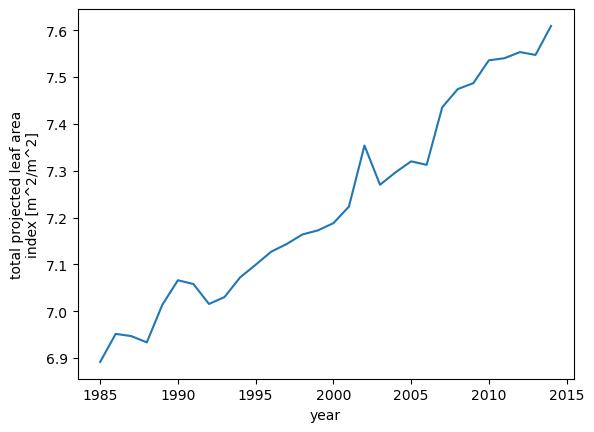

In [11]:
out.TLAI_biome_amax.isel(biome=1).plot()

In [ ]:
# load and process data
yr1 = 2015
yr2 = 2024

lafile = f='/glade/u/home/linnia/CLM6-PPE/utils/lapxb_sg_biomes_ctsm53065.nc'

files=sorted(glob.glob(dir+'*'+ens+'*.'+tape+'.*'))
filtered = filter_by_year(files,yr1,yr2)

f0=filter_by_year(sorted(glob.glob(dir+'*lhc0000*.'+tape+'.*')),yr1,yr2)
if len(filtered)<len(f0):
    bad=True
    filtered=f0
else:
    bad=False
    
ds=xr.open_mfdataset(filtered,combine='by_coords',preprocess=pp,decode_timedelta=True)

# calculate pft mean
out_2015=xr.Dataset()
    
for v in dvs:
    if v=='TLAI':
        x=amax(ds[v].sel(time=slice(str(yr1),str(yr2))))
        out_2015[v+'_biome_amax'] = pxbmean(x)
    else:
        x=amean(ds[v].sel(time=slice(str(yr1),str(yr2))))
        out_2015[v+'_biome_amean'] = pxbmean(x)

    for dv in out.data_vars:
        if v in dv:
            out_2015[dv].attrs=ds[v].attrs
